In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg
import xarray as xr
from scipy.signal import stft
from cdb_extras import xarray_support as cdbxr   # načítání dat z databáze COMPASSu
from pyCDB import client

cdb = client.CDBClient()
os.chdir('/compass/Shared/Users/bogdanov/vyzkumny_ukol/')

import imgs_processing as imgs


In [2]:
shot = 17837

# Load data from CDB
h_alpha_signal = cdb.get_signal(f"H_alpha/SPECTROMETRY_RAW:{shot}")
mc_signal = cdb.get_signal(f"Mirnov_coil_A_theta_13_RAW/MAGNETICS_RAW:{shot}")
divlp_signal = cdb.get_signal(f"DIVLPB01/STRATUS:{shot}")

# Convert data to pandas dataframe
h_alpha_df = pd.DataFrame({'time':h_alpha_signal.time_axis.data, 'h_alpha':h_alpha_signal.data}) 
mc_df = pd.DataFrame({'time':mc_signal.time_axis.data, 'mc':mc_signal.data})
div_df = pd.DataFrame({'time':divlp_signal.time_axis.data, 'divlp':divlp_signal.data})

# Merge dataframes
signals_df = pd.merge(div_df, pd.merge(h_alpha_df, mc_df, on='time', how='inner'), on='time', how='inner')


signals_df['h_alpha']*=-1
signals_df.set_index('time', inplace=True)

# Remove data with no plasma
discharge_start, discharge_end = imgs.discharge_duration(shot, 4e4)
signals_df = signals_df[np.logical_and(signals_df.index>discharge_start, signals_df.index<discharge_end)]

In [3]:
from scipy.signal import spectrogram

# Function to plot a spectrogram
def create_spectrogram(signal, fs, start_time, title):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=4000, noverlap=3000)
    t+=start_time

    return f, t, Sxx

fs = 1 / np.mean(np.diff(signals_df.index)) #in kHz
# Plotting spectrograms for each signal
f_divlp, t_divlp, Sxx_divlp = create_spectrogram(signals_df['divlp'], title='Spectrogram of divlp Signal', fs=fs, start_time=signals_df.index[0])
f_h_alpha, t_h_alpha, Sxx_h_alpha = create_spectrogram(signals_df['h_alpha'], title='Spectrogram of h_alpha Signal', fs=fs, start_time=signals_df.index[0])
f_mc, t_mc, Sxx_mc = create_spectrogram(signals_df['mc'], title='Spectrogram of mc Signal', fs=fs, start_time=signals_df.index[0])

In [4]:
frequency_threshold = 300 #kHz

xr_spectrogram_divlp = xr.DataArray(Sxx_divlp, dims=['frequency', 'time'], coords={'frequency': f_divlp, 'time': t_divlp}, name='mc')
xr_spectrogram_h_alpha = xr.DataArray(Sxx_h_alpha, dims=['frequency', 'time'], coords={'frequency': f_h_alpha, 'time': t_h_alpha}, name='mc')
xr_spectrogram_mc = xr.DataArray(Sxx_mc, dims=['frequency', 'time'], coords={'frequency': f_mc, 'time': t_mc}, name='mc')

divlp_filtered = xr_spectrogram_divlp.where(xr_spectrogram_divlp.frequency <= frequency_threshold, drop=True)
h_alpha_filtered = xr_spectrogram_h_alpha.where(xr_spectrogram_h_alpha.frequency <= frequency_threshold, drop=True)
mc_filtered = xr_spectrogram_mc.where(xr_spectrogram_mc.frequency <= frequency_threshold, drop=True)

ds_filtered = xr.Dataset({
    'divlp': divlp_filtered,
    'h_alpha': h_alpha_filtered,
    'mc': mc_filtered
})

In [5]:
ds_filtered

<xarray.Dataset>
Dimensions:    (frequency: 704, time: 723)
Coordinates:
  * frequency  (frequency) float64 0.0 0.4264 0.8528 1.279 ... 298.9 299.3 299.8
  * time       (time) float64 964.9 965.5 966.1 ... 1.388e+03 1.388e+03
Data variables:
    divlp      (frequency, time) float64 2.693e-06 1.707e-05 ... 4.56e-09
    h_alpha    (frequency, time) float64 5.967e-05 0.0007187 ... 1.059e-09
    mc         (frequency, time) float64 1.448e-09 4.636e-06 ... 4.253e-08

In [8]:
h_alpha_norm

<xarray.DataArray 'h_alpha' (frequency: 704, time: 723)>
array([[0.71993169, 0.8063318 , 0.80915525, ..., 0.46558538, 0.56806984,
        0.58595634],
       [0.92283557, 0.93131327, 0.89732646, ..., 0.59099802, 0.5727087 ,
        0.68774034],
       [0.86504256, 0.93265414, 0.9193871 , ..., 0.66224628, 0.67542989,
        0.68953756],
       ...,
       [0.36037999, 0.33551603, 0.36330196, ..., 0.44525621, 0.44679433,
        0.43465772],
       [0.32199445, 0.31351462, 0.31094544, ..., 0.3934348 , 0.38116114,
        0.35028888],
       [0.32207284, 0.21366359, 0.32319703, ..., 0.34238007, 0.35228578,
        0.3401308 ]])
Coordinates:
  * frequency  (frequency) float64 0.0 0.4264 0.8528 1.279 ... 298.9 299.3 299.8
  * time       (time) float64 964.9 965.5 966.1 ... 1.388e+03 1.388e+03

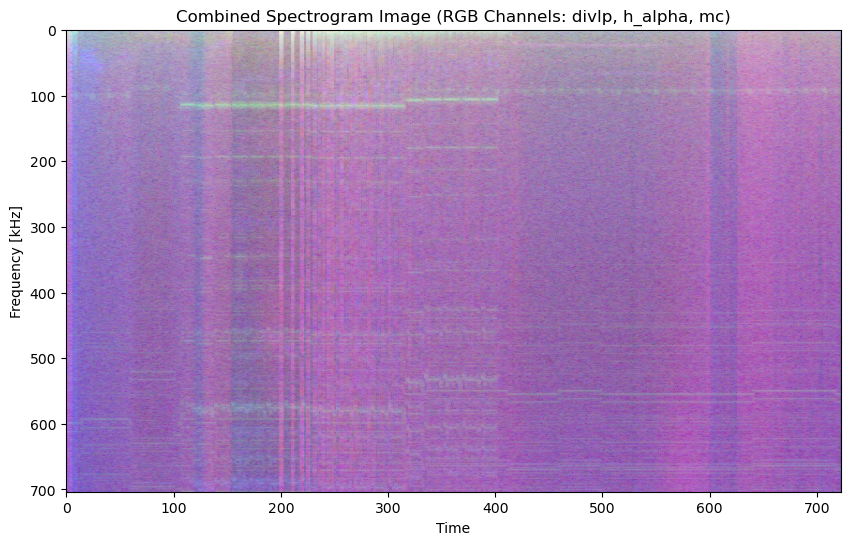

In [6]:
def normalize_data(da):
    return (da - da.min()) / (da.max() - da.min())

divlp_norm = normalize_data(np.log10(ds_filtered['divlp']))
h_alpha_norm = normalize_data(np.log10(ds_filtered['h_alpha']))
mc_norm = normalize_data(np.log10(ds_filtered['mc']))

# Ensure all DataArrays are of the same shape (this is necessary for them to be combined into a single image)
shape = divlp_norm.shape
h_alpha_norm = h_alpha_norm.interp_like(divlp_norm, method='nearest')
mc_norm = mc_norm.interp_like(divlp_norm, method='nearest')

# Combine the normalized data into a single 3-channel (RGB) image
rgb_image = np.stack([divlp_norm, h_alpha_norm, mc_norm], axis=-1)

# Plotting the RGB image
plt.figure(figsize=(10, 6))
plt.imshow(rgb_image, aspect='auto')
plt.title('Combined Spectrogram Image (RGB Channels: divlp, h_alpha, mc)')
plt.xlabel('Time')
plt.ylabel('Frequency [kHz]')
plt.show()

In [7]:
f.shape


NameError: name 'f' is not defined

In [ ]:
xr_spectrogram_mc.where(xr_spectrogram_mc.frequency <= 300, drop=True)

<xarray.DataArray 'mc' (frequency: 704, time: 195)>
array([[2.38316840e-05, 1.38661804e-05, 5.12261474e-06, ...,
        3.32411302e-07, 4.16840084e-08, 1.99923878e-12],
       [1.13415165e-04, 3.70043240e-05, 1.47620470e-04, ...,
        3.49120409e-05, 8.66337469e-06, 1.47163351e-05],
       [1.97366096e-05, 1.13033128e-04, 3.39720162e-05, ...,
        5.32753184e-06, 2.33915753e-06, 5.24182147e-06],
       ...,
       [3.01640692e-05, 1.00875631e-06, 6.06827721e-06, ...,
        7.76780035e-07, 1.44089511e-07, 2.03581944e-08],
       [2.31472005e-05, 1.41161963e-05, 2.27004120e-06, ...,
        2.93543218e-07, 1.14521938e-06, 2.96931082e-07],
       [6.94274624e-05, 2.93882756e-07, 2.54767866e-07, ...,
        2.74931095e-07, 1.57124875e-08, 7.63076973e-08]])
Coordinates:
  * frequency  (frequency) float64 0.0 0.4264 0.8529 1.279 ... 298.9 299.4 299.8
  * time       (time) float64 964.8 967.0 969.2 ... 1.388e+03 1.391e+03

In [ ]:
signals_df.loc[963.7250, 'mc']

-0.07264041429747413

In [ ]:
first_signal = signals_df.iloc[256]

In [ ]:
time_resolution

0.0033333333333333335

In [ ]:
reference_time 

963.722

In [ ]:
pwd


'/compass/Shared/Users/bogdanov/vyzkumny_ukol'

In [ ]:
import re
files = os.listdir('data/LP_MC_H_alpha_old. Different time resolution for each shot')
shot_numbers = [re.search(r'shot_(\d+)', file_name).group(1) for file_name in files]
time_resolution = pd.DataFrame({'shot':[], 'frequency for t 256, 255':[], 'mean freq':[]})

for file, shot in zip(files, shot_numbers):
    df = pd.read_csv(f'data/LP_MC_H_alpha_old. Different time resolution for each shot/{file}')
    dt = 1/(df['time'][256] - df['time'][255])
    time_resolution = pd.concat([time_resolution, pd.DataFrame({'shot':[shot], 'frequency for t 256, 255': [dt], 'mean freq': [1/np.mean(np.diff(df['time']))]})])

In [ ]:

time_resolution.sort_values(by='shot', ascending=True, inplace=True)
time_resolution.set_index('shot').to_csv('data/LP_MC_H_alpha_old. Different time resolution for each shot/time_resolution.csv')

In [ ]:
time_resolution

,shot,time_resolution
0,13182,166.666667
0,16532,181.818182
0,16534,166.666667
0,16769,153.846154
0,16773,153.846154
0,16987,166.666667
0,16989,166.666667
0,17677,166.666667
0,17837,153.846154
0,17839,153.846154


In [ ]:
desired_frequency = 300
time_resolution = 1/desired_frequency

reference_time = signals_df.index[0]

skip_rows = 0
while signals_df.index[skip_rows] - reference_time  < time_resolution:
    skip_rows+=1

In [ ]:
fs = 1 / np.mean(np.diff(signals_df.index)) #in kHz
signals_df.time()

,divlp,h_alpha,mc
time,,,
963.7220,-0.000940,0.512335,-0.054831
963.7230,-0.000705,0.510842,-0.067329
963.7235,-0.000235,0.512807,-0.067329
963.7245,-0.000940,0.513514,-0.064829
963.7250,-0.000705,0.506047,-0.072640
...,...,...,...
1389.4655,-0.002820,0.114996,0.023283
1389.4660,-0.002585,0.115232,0.012659
1389.4665,0.001646,0.116568,0.008910
